In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import re 
import cv2
import json
import collections
import tensorflow
import keras
from time import time 
import nltk
import pickle
# from nltk.corpus import stopwards
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50,preprocess_input
from keras.models import Model,load_model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.layers import Dropout,Dense,Flatten,Input,LSTM,Embedding
from keras.layers.merge import add

Using TensorFlow backend.


# Read Text Data Function

In [2]:
def readtextfiles(path):
    
    with open (path) as f:
        
        captions = f.read()
        
    return captions

# Read Captions of images 

In [3]:
captions = readtextfiles('/home/manik/Downloads/flickr8k (1)/flickr_data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt')

# create dictionary of the captions with image as key

captions=captions.split('\n')

captions = captions[:-1]

description = {}

for x in captions:
    
    first,second = x.split('\t')
    
    image_id = first.split('.')[0]
    
    if  description.get(image_id) is None:
        
        description[image_id]=[]
        
    description[image_id].append(second)


# Data Cleaning 

In [4]:
def clean_txt(sentence):
    
    sentence = sentence.lower()
    
    sentence = re.sub("[^a-z]+"," ",sentence)
    
    sentence=sentence.split(" ")
    
    sentence = [s for s in sentence if len(s)>1]
    
    sentence =" ".join(sentence)
    
    return sentence


for key,captions in description.items():
    
    for i in range(len(captions)):
        
        captions[i]=clean_txt(captions[i])
    
with open("/home/manik/Downloads/flickr8k (1)/Description_of_images.txt","w") as f:
    
    f.write(str(description))

# Create A vocab

In [50]:
with open("/home/manik/Downloads/flickr8k (1)/Description_of_images.txt","r") as f:
    
    description = f.read()
    
description = json.loads(description.replace("'","\""))

unique_word = set()

for key in description:
    
    [unique_word.update(sentence.split()) for sentence in description[key]]
    
total_word = []

for key in description:
    
    [total_word.append(word) for sentence in description[key] for word in sentence.split()]

Count = collections.Counter(total_word)

vocab = set()

for word in unique_word:
     if Count[word]>10:
            vocab.add(word)

vocab.add("startseq")
vocab.add("endseq")

# Prepare Train And Test Data

In [6]:

with open("/home/manik/Downloads/flickr8k (1)/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt") as f:
   
    train_data = f.read().split("\n")[:-1]
    

with open("/home/manik/Downloads/flickr8k (1)/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt") as f:
   
    test_data =f.read().split("\n")[:-1]
    

train_description = {}

for image_id in train_data:
    
    image_id = image_id.split(".")[0]
    
    train_description[image_id] = []
    
    for x in description[image_id]:
        
        train_description[image_id].append(" startseq "+x+" endseq ")
    


# Image Feature Extraction

In [7]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))

model.summary()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
_________

In [8]:
model_new=Model(model.input,model.layers[-2].output)

def preprocess_img(img):
    
    img=image.load_img(img,target_size=(224,224))
    
    img=image.img_to_array(img)
    
    img=np.expand_dims(img,axis=0)
    
    # normalisation
    
    img=preprocess_input(img)
    
    return img
    
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


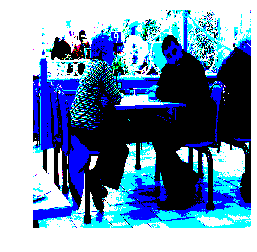

In [9]:
img=preprocess_img("/home/manik/Downloads/flickr8k (1)/Flickr_Data/Flickr_Data/Images/2206594874_5e0087c6b7.jpg")
plt.imshow(img[0])
plt.axis("off")
plt.show()

In [15]:
def encode(img):
    
    img=preprocess_img(img)
    
    feature_vector=model_new.predict(img)
    
    feature_vector=feature_vector.reshape((-1))
        
    return feature_vector


IMG_PATH="/home/manik/Downloads/flickr8k (1)/Flickr_Data/Flickr_Data/Images/"

encoding_train={}

start =time()

for i ,img_id in enumerate(train_data):
    
    img=IMG_PATH+img_id
    
    encoding_train[img_id]=encode(img)
    
    if i%100==0:
        print("IN Progress")
        
end_t=time()

print("time taken %d"%(end_t-start))

    
    
    
    
# encode("/home/manik/Downloads/flickr8k (1)/Flickr_Data/Flickr_Data/Images/2206594874_5e0087c6b7.jpg")

IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
time taken 1592


TypeError: write() argument must be str, not bytes

In [19]:
 with open ("Preprocessed_images.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [20]:
IMG_PATH="/home/manik/Downloads/flickr8k (1)/Flickr_Data/Flickr_Data/Images/"

encoding_test={}

for i, img_id in enumerate(test_data):
    
    img=IMG_PATH+img_id
    
    encoding_test[img_id]=encode(img)
    
    if i%100==0:
        print("IN Progress")
        
with open ("Preprocessed_test_images.pkl","wb") as f:
    pickle.dump(encoding_test,f)

IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress
IN Progress


# Caption Preprocessing

In [72]:
word_to_idx={}

idx_to_word={}

for i,word in enumerate(vocab):
    
    word_to_idx[word]=i+1
    
    idx_to_word[i+1]=word

maxlen=0

for key in train_description.keys():
    
    for cap in train_description[key]:
        
        maxlen=max(maxlen,len(cap.split()))
        
print(maxlen)

35


# Data Loader (Generator)

In [99]:
def data_loader(train_description,encoding_train,word_to_idx,maxlen,batch_size):
    
    X1,X2,Y=[],[],[]
    
    while True:
        
        n=0
        
        for key ,des in train_description.items():
            
            n+=1
            
            photo = encoding_train[key+".jpg"]
            
            for cap in train_description[key]:
                
                seq = [word_to_idx[word] for word in cap.split() if word in word_to_idx]
                
                for i in range(1,len(seq)):
                    
                    input_data,output_data = seq[:i],seq[i]
                    
                    input_data=pad_sequences([input_data],maxlen=maxlen,padding="post",value=0)[0]
                    
                    output_data=to_categorical(output_data,num_classes=len(vocab)+1)[0]
                    
                    X1.append(photo)
                    
                    X2.append(input_data)
                    
                    Y.append(output_data)
                    
            if n==batch_size:
                
                 yield [np.array(X1),np.array(X2),np.array(Y)]
                    
            X1,X2,Y=[],[],[]
            
            n=0
                    
                    
                
                    

# Word Embedding

In [91]:
f =open ('glove.6B.50d.txt')

In [92]:
embedding_idx ={}

for line in f:
    
    value=line.split()
    
    embedding_idx[value[0]]=np.array(value[1:],dtype="float")
    
def get_embedding_matrix():
    
    emd_dim=50
    
    matrix=np.zeros((len(vocab)+1,emd_dim))
    
    for word, idx in word_to_idx.items():
        
        embedding_vector=embedding_idx.get(word)
        
        if embedding_vector is not None:
            
            matrix[idx]=embedding_vector
        
    return matrix
    

In [93]:
embedding_matrix=get_embedding_matrix()

# Model Architecture

In [94]:

inputs1 = Input(shape=(2048,))

fe1 = Dropout(0.5)(inputs1)

fe2 = Dense(256, activation='relu')(fe1)



inputs2 = Input(shape=(maxlen,))

se1 = Embedding(input_dim=len(vocab)+1,output_dim=50, mask_zero=True)(inputs2)

se2 = Dropout(0.5)(se1)

se3 = LSTM(256)(se2)



decoder1 = add([fe2, se3])

decoder2 = Dense(256, activation='relu')(decoder1)

outputs = Dense(len(vocab)+1, activation='softmax')(decoder2)



model = Model(inputs=[inputs1, inputs2], outputs=outputs)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 35)           0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 35, 50)       92400       input_10[0][0]                   
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, 2048)         0           input_9[0][0]                    
____________________________________________________________________________________________

In [95]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable=False
model.compile(loss="categorical_crossentropy",optimizer="adam")

#  Train Model

In [96]:
epochs = 20

batch =3

steps =len(train_description)//5

def train():
    
    for i in range(epochs):
        
        generator = data_loader(train_description,encoding_train,word_to_idx,maxlen,batch)
        
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        
        model.save('/home/manik/model_weights/model_'+str(i)+'.h5')
        

In [101]:
train()

Epoch 1/1


KeyboardInterrupt: 